# Tutorial CV2 - Function fitting with a quantum neural network

In this tutorial we show how a variational circuit can be used to extrapolate a one- or two-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is described in Killoran et al. 2018 (arxiv 1806.06871), where it was called a continuous-variable quantum neural network. The name stems from the fact that with a slight alternation of how to implement the nonlinear

## 1. One dimension

### Imports

We execute the standard imports.

In [1]:
import openqml as qm
from openqml import numpy as np
from openqml._optimize import NesterovMomentumOptimizer

12:53:41 WARNING No OpenQML configuration file found.


The device is again the StrawberryFields simulator, this time with only one quantum mode or "wire".

In [2]:
dev = qm.device('strawberryfields.fock', wires=1, cutoff_dim=10)

12:53:43 WARNING /usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)

12:53:43 WARNING /usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



### Quantum function

According to (REF CVQNN) a (single mode) layer of the variational circuit is defined as:

In [3]:
def layer(w):
    """ Single layer of the continuous-variable quantum neural net."""

    # Matrix multiplication of input layer
    qm.Rotation(w[0], [0])
    qm.Squeezing(w[1], 0., [0])
    qm.Rotation(w[2], [0])

    # Bias
    qm.Displacement(w[3], 0., [0])

    # Element-wise nonlinear transformation
    qm.Kerr(w[4], [0])

The variational circuit in the quantum function first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qm.qfunc(dev)
def quantum_neural_net(weights, x=None):
    """The quantum neural net variational circuit."""

    qm.Displacement(x[0], 0., [0])

    for w in weights:
        layer(w)

    return qm.expectation.X(0)


### Objective

As an objective we take the square loss between target labels and model predictions.

In [14]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we take the outputs as direct predictions (i.e. without applying a final sign, sigmoid or other function).

In [9]:
def cost(weights, features, labels):

    predictions = [quantum_neural_net(weights, x=x) for x in features]

    return square_loss(labels, predictions)

### Optimization

We load noisy data samples of a sine function.

In [10]:
data = np.loadtxt("sine.txt")
X = data[:, :-1]
Y = data[:, -1]

The weights are initialized with values sampled from a normal distribution.

In [11]:
num_layers = 10
weights0 = np.random.randn(num_layers, 5)

weights0[0]

array([-0.08001941, -0.36880224,  0.77710194, -0.91620406, -0.17532891])

We choose a Nestrov Momentum Optimizer and update the weights for 100 steps.

In [15]:
o = NesterovMomentumOptimizer(0.1)

weights = weights0
for iteration in range(10):

    weights = o.step(lambda w: cost(w, X, Y), weights)
    print("Iter: {:5d} | Cost: {:0.7f}".format(iteration, cost(weights, X, Y)))


Iter:     0 | Cost: 0.6302817
Iter:     1 | Cost: 0.6273696
Iter:     2 | Cost: 0.6272546
Iter:     3 | Cost: 0.6308791
Iter:     4 | Cost: 0.6307181
Iter:     5 | Cost: 0.6267591
Iter:     6 | Cost: 0.6268291
Iter:     7 | Cost: 0.6267627
Iter:     8 | Cost: 0.6267586
Iter:     9 | Cost: 0.6267586
Iter:    10 | Cost: 0.6267586
Iter:    11 | Cost: 0.6267586
Iter:    12 | Cost: 0.6267586
Iter:    13 | Cost: 0.6267586
Iter:    14 | Cost: 0.6267586


Finally, we collect the predictions of the trained model for a x values between $[-1,1]$...

In [19]:
x_axis = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(weights, x=x) for x in x_axis]

...import a plotting library...

In [17]:
import matplotlib.pyplot as plt

...and plot the noisy data (red) and predictions (green).

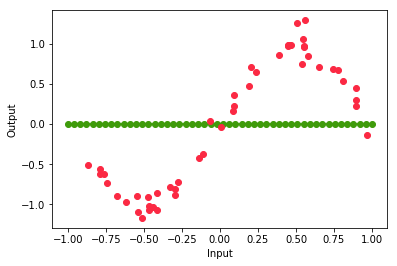

In [23]:
plt.figure()

plt.plot(x_axis, predictions, color='#3f9b0b', marker='o',zorder=1)
plt.scatter(X, Y, color='#fb2943', marker='o', zorder=2)
plt.xlabel('Input')
plt.ylabel('Output')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

## 2. Fitting higher dimensional functions

If the function input/output is of higher dimensions, we can adapt the layer structure, initial weights, and quantum function accordingly. TEST!

In [ ]:
def layer(W, b):

    U, d, V = np.linalg.grad_svd(W)

    # Matrix multiplication of input layer
    qm.Interferometer(U, [0, 1])
    qm.Squeezing(-np.log(d[0]), [0])
    qm.Interferometer(V, [0, 1])

    # Bias
    qm.Displacement(b[0], [0])

    # Element-wise nonlinear transformation
    qm.Kerr(0.1, [0])

In [ ]:
@qm.qfunc(dev)
def quantum_neural_net(weights, x=None):

        
    for idx in range(len(x)):
        qm.Displacement(x[i], [idx])

    for W, b in weights:
        layer(W, b)
        
    
    expectations = [qm.expectation.X(idx) for idx in range(len(x))]

    return tuple(expectations)

In [ ]:
def make_random_layer(num_modes):
    W = np.random.randn(num_modes, num_modes)
    b = np.random.randn(num_modes)
    return W, b

num_modes = ...
weights0 = [make_random_layer(num_modes)]